In [1]:
import os

import himalaya.scoring
import numpy as np
import pandas as pd
import simplstyles
import matplotlib.pyplot as plt
import seaborn as sns
import voxelwise_tutorials.viz as viz
from himalaya.backend import set_backend
from matplotlib import pyplot as plt
from scipy.stats import zscore
from sklearn.pipeline import make_pipeline

from compare_variance_residual.stimuli_utils.TemporalChunkSplitter import TemporalChunkSplitter
from compare_variance_residual.variance_partitioning import solver_params

In [2]:
def get_result_path(modality, subject):
    path = os.path.join("results", modality, f"subject{subject:02}")
    os.makedirs(path, exist_ok=True)
    return path

In [3]:
plt.style.use('nord-light-talk')
data_dir = "../data"
backend = set_backend('torch_cuda', on_error='warn')

In [4]:
language_model = "bert-base"
layer = 9
num_layers = 12
feature = "semantic"
modality = "reading"
subject = 1
low_level_feature = "letters"
trim = 5  # remove 5 TRs from the start and end of each story
sequence_length = 20
number_of_delays = 4

In [5]:
alphas = np.logspace(-5, 5, 10)
n_iter = 25
n_targets_batch = 100
n_alphas_batch = 5
n_targets_batch_refit = 100
n_splits = 15
chunk_len = 40
num_chunks = 10
# cv = TemporalChunkSplitter(num_splits=n_splits, chunk_len=chunk_len, num_chunks=num_chunks)
cv = 5
score_func = himalaya.scoring.r2_score

In [6]:
from himalaya.scoring import r2_score
from voxelwise_tutorials.delayer import Delayer
from himalaya.ridge import BandedRidgeCV, ColumnTransformerNoStack


def run_pipeline(features_train, features_val, n_features_list, target_train, targets_val):
    delayer = Delayer(delays=range(1, number_of_delays + 1))

    start_and_end = np.concatenate([[0], np.cumsum(n_features_list)])
    slices = [
        slice(start, end)
        for start, end in zip(start_and_end[:-1], start_and_end[1:])
    ]
    ct = ColumnTransformerNoStack(transformers=[(f'feature_{i}', delayer, s) for i, s in enumerate(slices)])
    print(ct)

    solver_params = dict(
        alphas=alphas,
        n_iter=n_iter,
        n_targets_batch=n_targets_batch,
        n_alphas_batch=n_alphas_batch,
        n_targets_batch_refit=n_targets_batch_refit,
        score_func=score_func
    )
    banded_ridge_cv = BandedRidgeCV(cv=cv, groups="input", solver_params=solver_params)

    pipeline = make_pipeline(
        ct,
        banded_ridge_cv
    )
    pipeline.fit(features_train, target_train)

    correlation_scores = []
    r2_scores = []
    for target_val in targets_val:
        prediction = pipeline.predict(features_val)
        prediction = prediction.cpu().numpy()

        # calculate correlation for each target
        correlation_score = np.array(
            [np.corrcoef(target_val[:, i], prediction[:, i])[0, 1] for i in range(target_val.shape[1])])
        print(correlation_score.shape)
        correlation_scores.append(correlation_score)

        r2 = r2_score(target_val, prediction)
        r2 = r2.cpu().numpy()
        r2_scores.append(r2)

    scores = pd.DataFrame(
        {
            'correlation_score_0': correlation_scores[0],
            'correlation_score_1': correlation_scores[1],
            'r2_score_0': r2_scores[0],
            'r2_score_1': r2_scores[1]
        }
    )
    return scores

In [7]:
def plot_flatmap_from_mapper(voxels, mapper_file, ax=None, alpha=0.7, cmap=plt.get_cmap(), vmin=None, vmax=None,
                             with_curvature=True, with_rois=True, with_colorbar=True,
                             colorbar_location=(.4, .9, .2, .05)):
    """Plot a flatmap from a mapper file, with 1D data.

    This function is equivalent to the pycortex functions:
    cortex.quickshow(cortex.Volume(voxels, ...), ...)

    Note that this function does not have the full capability of pycortex,
    since it is based on flatmap mappers and not on the original brain
    surface of the subject.

    Parameters
    ----------
    voxels : array of shape (n_voxels, )
        Data to be plotted.
    mapper_file : str
        File name of the mapper.
    ax : matplotlib Axes or None.
        Axes where the figure will be plotted.
        If None, a new figure is created.
    alpha : float in [0, 1], or array of shape (n_voxels, )
        Transparency of the flatmap.
    cmap : str
        Name of the matplotlib colormap.
    vmin : float or None
        Minimum value of the colormap. If None, use the 1st percentile of the
        `voxels` array.
    vmax : float or None
        Minimum value of the colormap. If None, use the 99th percentile of the
        `voxels` array.
    with_curvature : bool
        If True, show the curvature below the data layer.
    with_rois : bool
        If True, show the ROIs labels above the data layer.
    colorbar_location : [left, bottom, width, height]
        Location of the colorbar. All quantities are in fractions of figure
        width and height.

    Returns
    -------
    ax : matplotlib Axes
        Axes where the figure has been plotted.
    """
    # create a figure
    if ax is None:
        flatmap_mask = load_hdf5_array(mapper_file, key='flatmap_mask')
        figsize = np.array(flatmap_mask.shape) / 100.
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes((0, 0, 1, 1))
        ax.axis('off')

    # process plotting parameters
    vmin = np.percentile(voxels, 1) if vmin is None else vmin
    vmax = np.percentile(voxels, 99) if vmax is None else vmax
    if isinstance(alpha, np.ndarray):
        alpha = viz.map_voxels_to_flatmap(alpha, mapper_file)

    # plot the data
    image = viz.map_voxels_to_flatmap(voxels, mapper_file)
    cimg = ax.imshow(image, aspect='equal', zorder=1, alpha=alpha, cmap=cmap,
                     vmin=vmin, vmax=vmax)

    if with_colorbar:
        try:
            cbar = ax.inset_axes(colorbar_location)
        except AttributeError:  # for matplotlib < 3.0
            cbar = ax.figure.add_axes(colorbar_location)
        colorbar = ax.figure.colorbar(cimg, cax=cbar, orientation='horizontal')
        colorbar.ax.set_title("Pearson Correlation of Y_true and Y_pred", fontsize=14)

    # plot additional layers if present
    viz._plot_addition_layers(ax=ax, n_voxels=voxels.shape[0],
                              mapper_file=mapper_file,
                              with_curvature=with_curvature, with_rois=with_rois)

    return ax

# Load Features

In [8]:
import h5py

features_train = h5py.File(os.path.join(data_dir, 'features', 'features_trn_NEW.hdf'), 'r')
features_val = h5py.File(os.path.join(data_dir, 'features', 'features_val_NEW.hdf'), 'r')
print(features_train.keys(), features_val.keys())
print(features_train['story_01'].keys())

<KeysViewHDF5 ['story_01', 'story_02', 'story_03', 'story_04', 'story_05', 'story_06', 'story_07', 'story_08', 'story_09', 'story_10']> <KeysViewHDF5 ['story_11']>
<KeysViewHDF5 ['english1000', 'letters', 'numletters', 'numphonemes', 'numwords', 'pauses', 'phonemes', 'word_length_std']>


## Load Low Level Feature

In [9]:
low_level_train = np.vstack([zscore(features_train[story][low_level_feature]) for story in features_train.keys()])
low_level_val = np.vstack([zscore(features_val[story][low_level_feature]) for story in features_val.keys()])
low_level_train, low_level_val = np.nan_to_num(low_level_train), np.nan_to_num(low_level_val)
print(low_level_train.shape, low_level_val.shape)

(3887, 26) (306, 26)


## Load High Level (NLP) Features

In [10]:
# downsampled_embeddings = np.load(f"../{language_model}{sequence_length}_downsampled.npy", allow_pickle=True)
# print(downsampled_embeddings.item().keys())

In [11]:
# Rstories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy',
#             'life', 'myfirstdaywiththeyankees', 'naked',
#             'odetostepfather', 'souls', 'undertheinfluence']
# Pstories = ['wheretheressmoke']
#
# semantic_embeddings_train = np.vstack([zscore(downsampled_embeddings.item()[story][layer]) for story in Rstories])
# semantic_embeddings_val = np.vstack([zscore(downsampled_embeddings.item()[story][layer]) for story in Pstories])
# semantic_embeddings_train, semantic_embeddings_val = np.nan_to_num(semantic_embeddings_train), np.nan_to_num(
#     semantic_embeddings_val)
# print(semantic_embeddings_train.shape, semantic_embeddings_val.shape)

In [12]:
semantic_train = np.vstack([zscore(features_train[story]['english1000']) for story in features_train.keys()])
semantic_val = np.vstack([zscore(features_val[story]['english1000']) for story in features_val.keys()])
print(semantic_train.shape, semantic_val.shape)

(3887, 985) (306, 985)


# Load Brain Data

In [13]:
from voxelwise_tutorials.io import load_hdf5_array

Y_train_filename = os.path.join(data_dir, 'responses', f'subject{subject:02}_{modality}_fmri_data_trn.hdf')
Y_train = load_hdf5_array(Y_train_filename)

Y_test_filename = os.path.join(data_dir, 'responses', f'subject{subject:02}_{modality}_fmri_data_val.hdf')
Y_test = load_hdf5_array(Y_test_filename)

Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
Ys_test = [np.vstack([zscore(Y_test[story][i][:-trim]) for story in Y_test.keys()]) for i in range(2)]

print(Y_train.shape, np.array(Ys_test).shape)
Y_train, Ys_test = np.nan_to_num(Y_train), np.nan_to_num(Ys_test)

/tmp/ipykernel_1915/893258922.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/tmp/ipykernel_1915/893258922.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/tmp/ipykernel_1915/893258922.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/tmp/ipykernel_1915/893258922.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellat

(3887, 81133) (2, 306, 81133)


## convert everything to float32

In [14]:
low_level_train = low_level_train.astype(np.float32)
low_level_val = low_level_val.astype(np.float32)
semantic_train = semantic_train.astype(np.float32)
semantic_val = semantic_val.astype(np.float32)
Y_train = Y_train.astype(np.float32)
Ys_test = [Y_test.astype(np.float32) for Y_test in Ys_test]

# Variance Partitioning

## Low Level Prediction

In [15]:
low_level_file = os.path.join(get_result_path(modality, subject), f"vp_low_level_{low_level_feature}_scores.csv")

In [46]:
if not os.path.exists(low_level_file):
    print(f"Saving {low_level_file}")
    vp_low_level_scores = run_pipeline(low_level_train, low_level_val, [low_level_train.shape[1]], Y_train, Ys_test)
    vp_low_level_scores.to_csv(low_level_file)
else:
    print(f"Loading {low_level_file}")
    vp_low_level_scores = pd.read_csv(low_level_file, index_col=0)

# remove nan values
print(vp_low_level_scores.max(), vp_low_level_scores.min(), vp_low_level_scores.mean())

Loading results/reading/subject01/vp_low_level_letters_scores.csv
correlation_score_0    0.524104
correlation_score_1    0.572667
r2_score_0             0.274330
r2_score_1             0.324543
dtype: float64 correlation_score_0   -0.322621
correlation_score_1   -0.253886
r2_score_0            -0.071299
r2_score_1            -0.063183
dtype: float64 correlation_score_0    0.028458
correlation_score_1    0.042405
r2_score_0             0.001434
r2_score_1             0.003204
dtype: float64


## Semantic Prediction

In [36]:
semantic_file = os.path.join(get_result_path(modality, subject), f"vp_semantic_{layer:02}_scores.csv")

In [47]:
if not os.path.exists(semantic_file):
    print(f"Saving {semantic_file}")
    vp_semantic_scores = run_pipeline(semantic_train, semantic_val, [semantic_train.shape[1]], Y_train, Ys_test)
    vp_semantic_scores.to_csv(semantic_file)
else:
    print(f"Loading {semantic_file}")
    vp_semantic_scores = pd.read_csv(semantic_file, index_col=0)

# remove nan values
print("max\n", vp_semantic_scores.max(), "\nmin\n", vp_semantic_scores.min(), "\nmean\n", vp_semantic_scores.mean())

Loading results/reading/subject01/vp_semantic_09_scores.csv
max
 correlation_score_0    0.492383
correlation_score_1    0.574922
r2_score_0             0.233523
r2_score_1             0.325578
dtype: float64 
min
 correlation_score_0   -0.300970
correlation_score_1   -0.307757
r2_score_0            -0.097761
r2_score_1            -0.162614
dtype: float64 
mean
 correlation_score_0    0.044188
correlation_score_1    0.044833
r2_score_0             0.002582
r2_score_1             0.002368
dtype: float64


## Joint Prediction

In [29]:
joint_file = os.path.join(get_result_path(modality, subject), f"vp_joint_{feature}_{low_level_feature}_scores.csv")

In [64]:
if not os.path.exists(joint_file):
    print(f"Saving {joint_file}")
    vp_joint_scores = run_pipeline(np.concatenate([semantic_train, low_level_train], axis=1),
                                   np.concatenate([semantic_val, low_level_val], axis=1),
                                   [semantic_train.shape[1], low_level_train.shape[1]], Y_train, Ys_test)
    vp_joint_scores.to_csv(joint_file)
else:
    print(f"Loading {joint_file}")
    vp_joint_scores = pd.read_csv(joint_file, index_col=0)

# remove nan values
print("max\n", vp_joint_scores.max(), "\nmin\n", vp_joint_scores.min(), "\nmean\n", vp_joint_scores.mean())

Loading results/reading/subject01/vp_joint_semantic_letters_scores.csv
max
 correlation_score_0    0.544771
correlation_score_1    0.606403
r2_score_0             0.274258
r2_score_1             0.347758
dtype: float64 
min
 correlation_score_0   -0.332179
correlation_score_1   -0.286146
r2_score_0            -0.129433
r2_score_1            -0.119829
dtype: float64 
mean
 correlation_score_0    0.048355
correlation_score_1    0.052851
r2_score_0             0.004815
r2_score_1             0.005523
dtype: float64


## Plot each brain map

In [43]:
mapper_path = os.path.join("../data", 'mappers', f"subject{subject:02}_mappers.hdf")
flatmap_mask = load_hdf5_array(mapper_path, key='flatmap_mask')

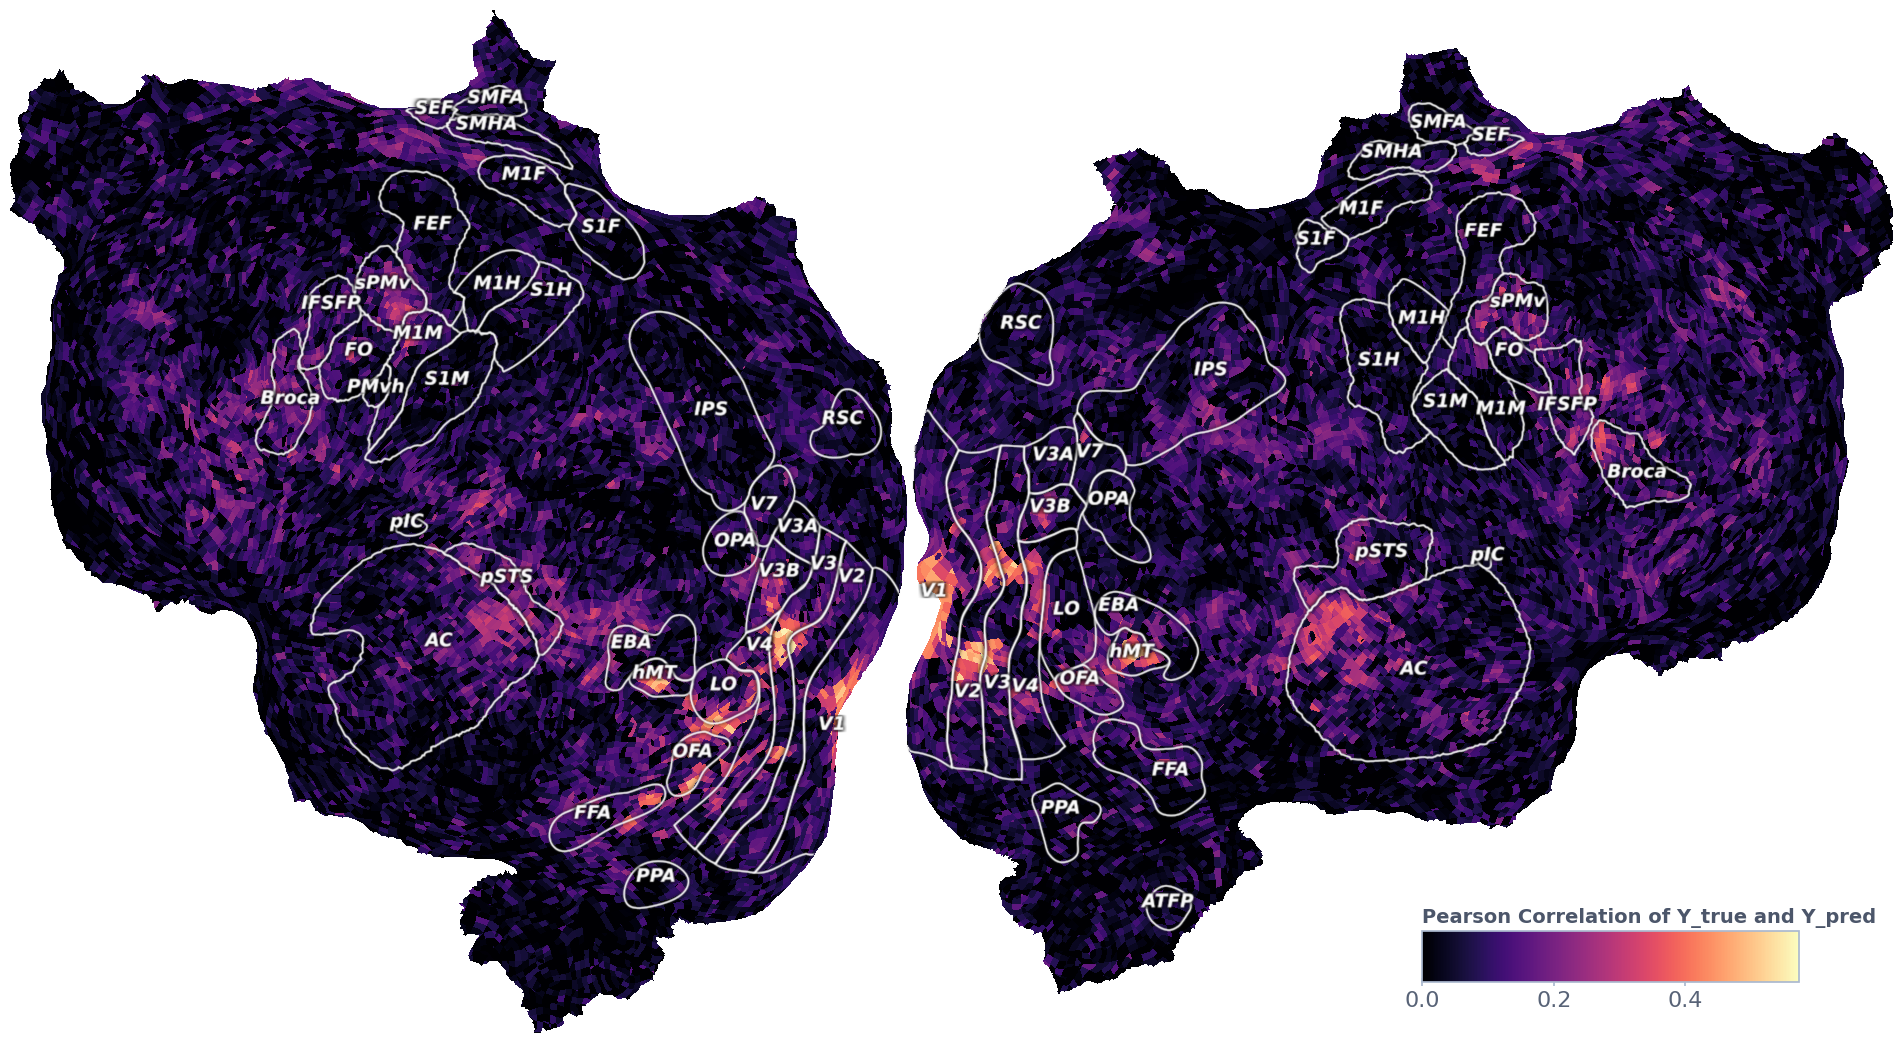

In [65]:
from scipy.stats import stats

figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

vp_low_level_correlation = vp_low_level_scores['correlation_score_1']
vp_low_level_correlation = vp_low_level_correlation.to_numpy()
vp_low_level_correlation = np.nan_to_num(vp_low_level_correlation)

plot_flatmap_from_mapper(vp_low_level_correlation, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         # vmin=np.min(correlation),
                         vmax=np.max(vp_low_level_correlation),
                         colorbar_location=[0.75, 0.05, 0.2, 0.05])

plt.show()

<Axes: >

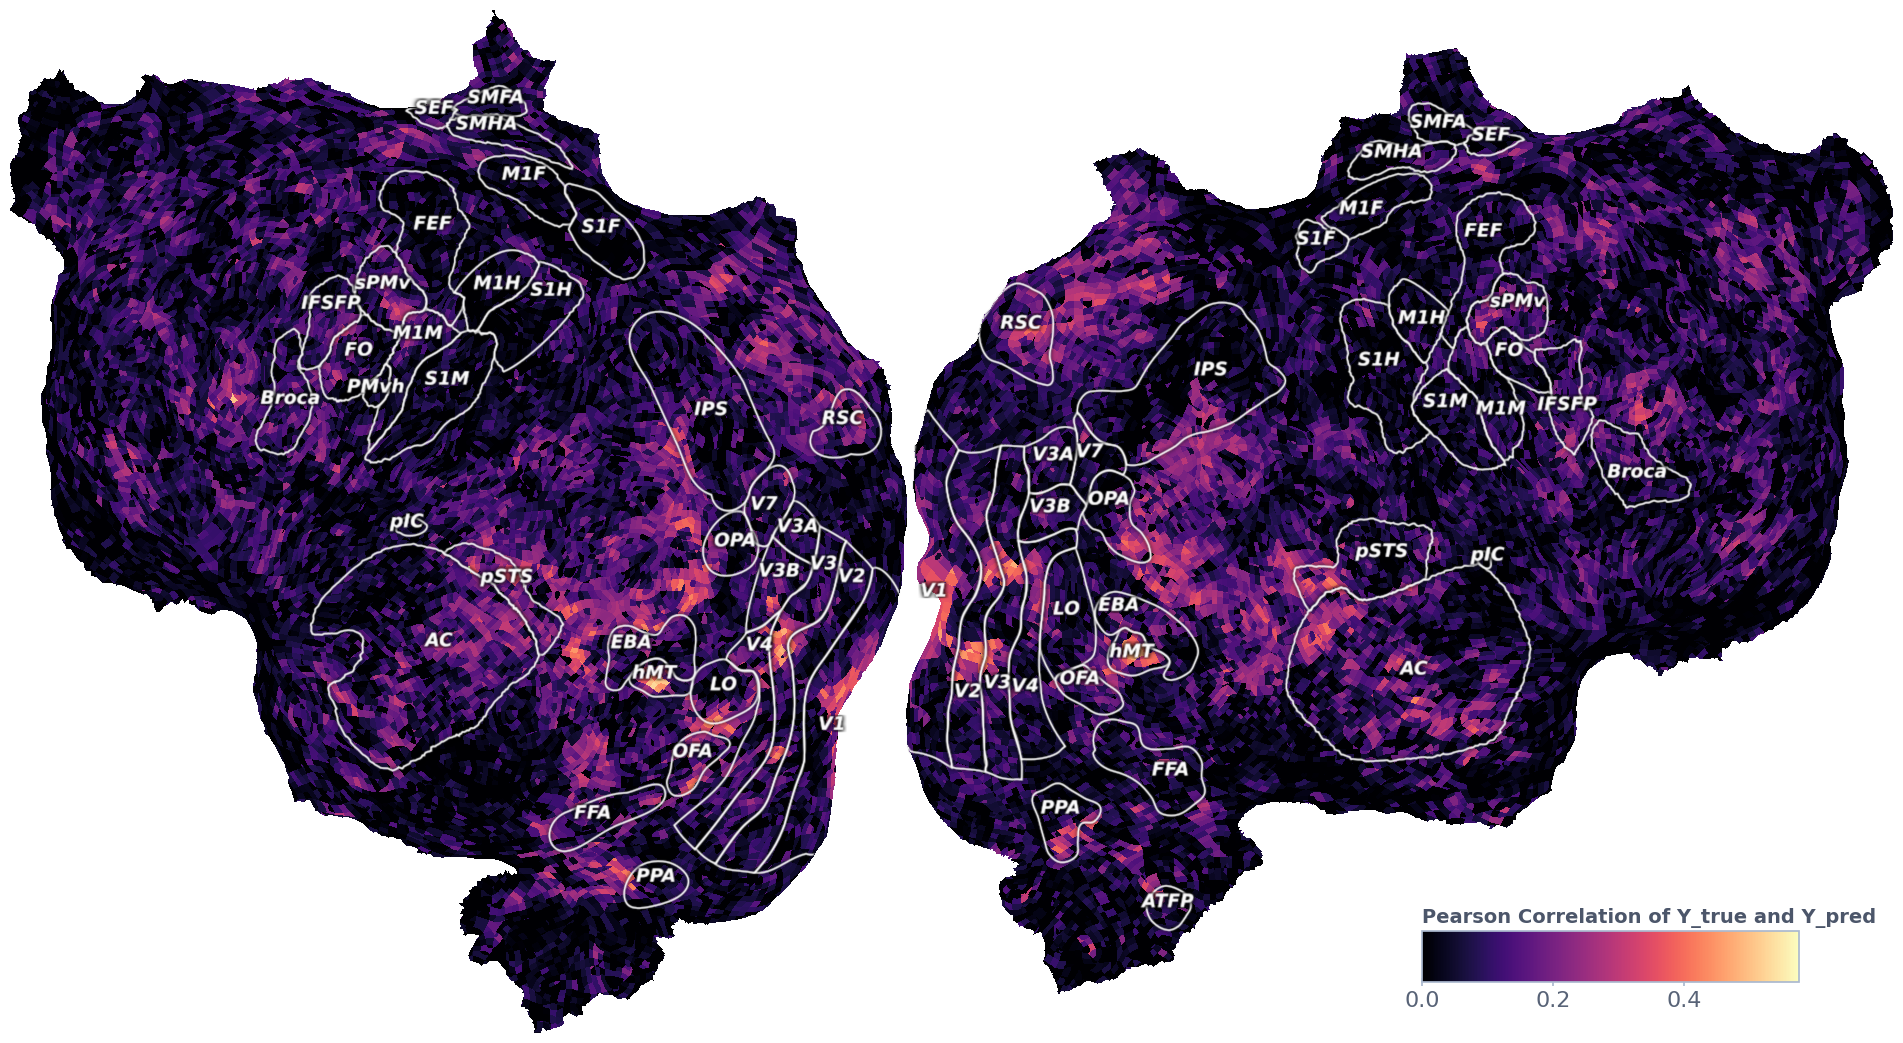

In [66]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

vp_semantic_correlation = vp_semantic_scores['correlation_score_1']
vp_semantic_correlation = vp_semantic_correlation.to_numpy()
vp_semantic_correlation = np.nan_to_num(vp_semantic_correlation)

plot_flatmap_from_mapper(vp_semantic_correlation, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=np.max(vp_semantic_correlation), colorbar_location=[0.75, 0.05, 0.2, 0.05])


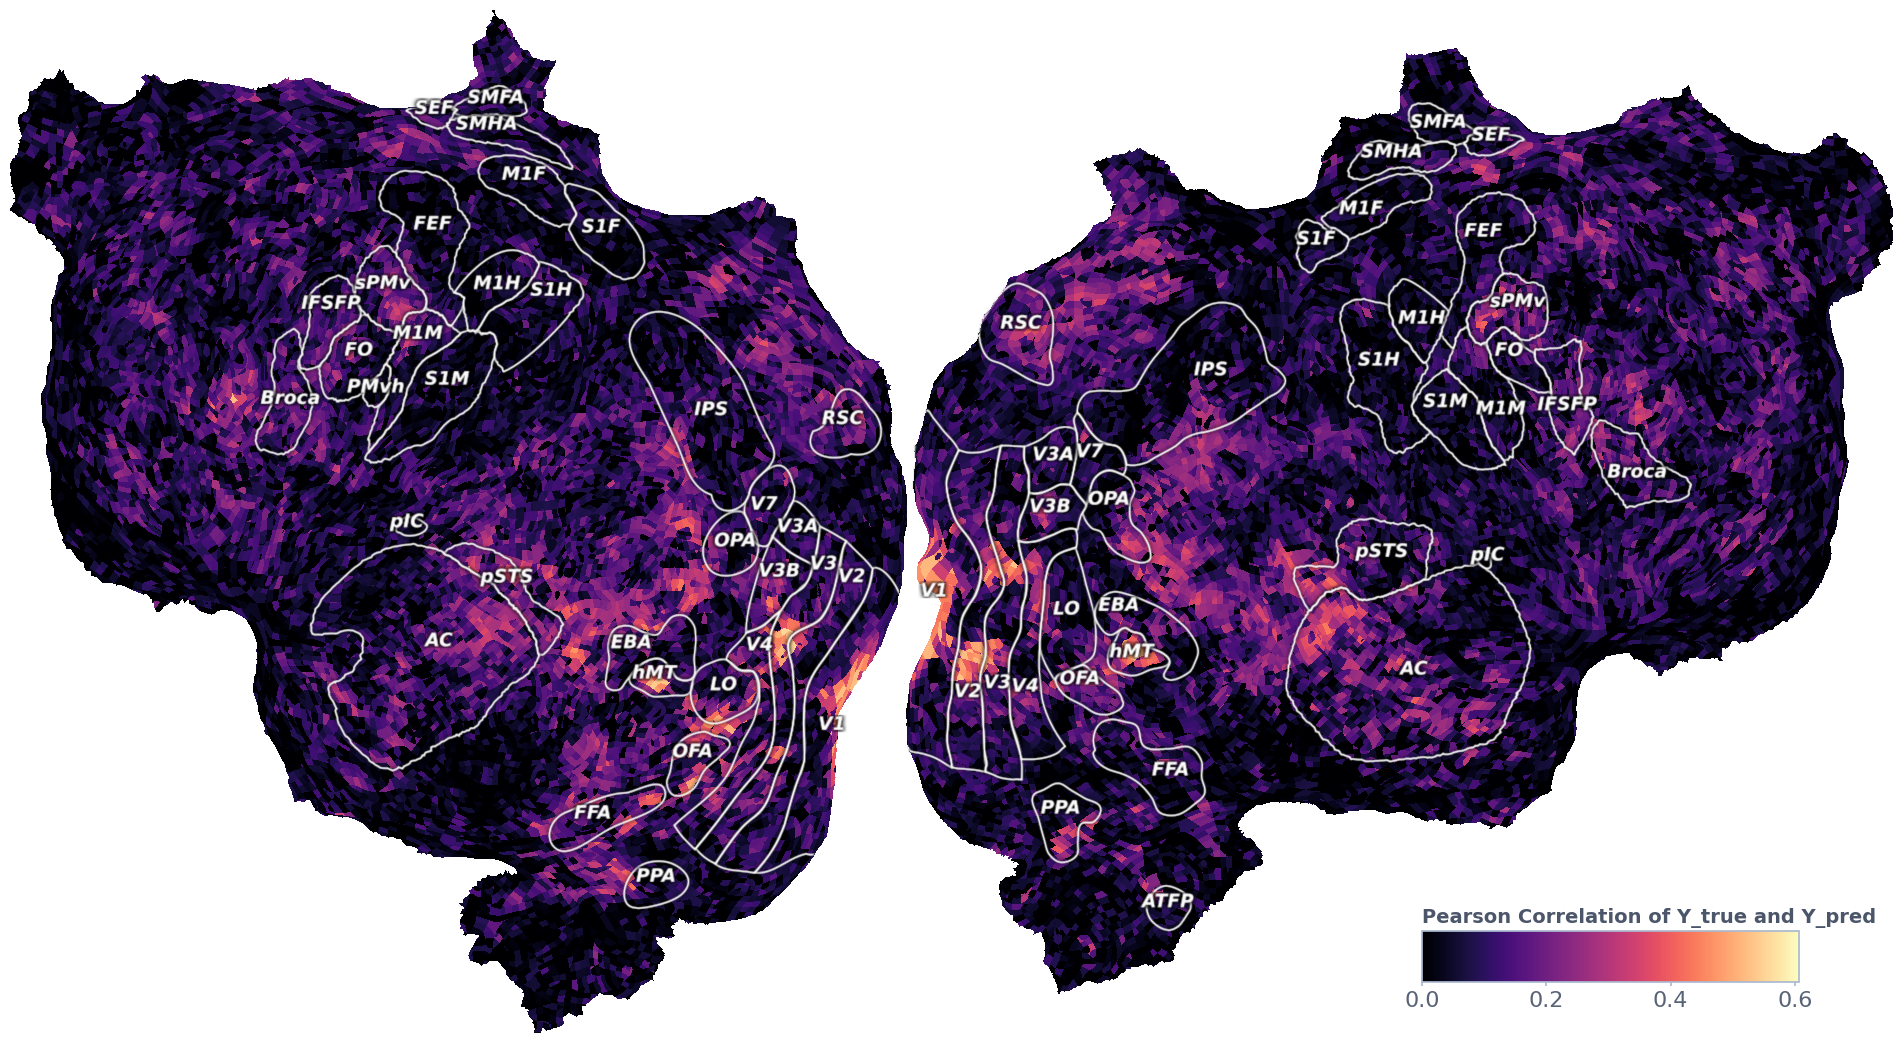

In [67]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

vp_joint_correlation = vp_joint_scores['correlation_score_1']
vp_joint_correlation = vp_joint_correlation.to_numpy()
vp_joint_correlation = np.nan_to_num(vp_joint_correlation)

plot_flatmap_from_mapper(vp_joint_correlation, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=np.max(vp_joint_correlation), colorbar_location=[0.75, 0.05, 0.2, 0.05])

plt.show()

## Perform Variance Partitioning

In [68]:
def signed_square(r):
    return r ** 2 * np.sign(r)


intersection = signed_square(vp_joint_scores['correlation_score_1']) + signed_square(
    vp_low_level_scores['correlation_score_1']) - signed_square(vp_semantic_scores['correlation_score_1'])
semantic_minus_low_level = signed_square(vp_semantic_scores['correlation_score_1']) - intersection
semantic_minus_low_level = np.sqrt(semantic_minus_low_level)
semantic_minus_low_level = np.nan_to_num(semantic_minus_low_level)

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


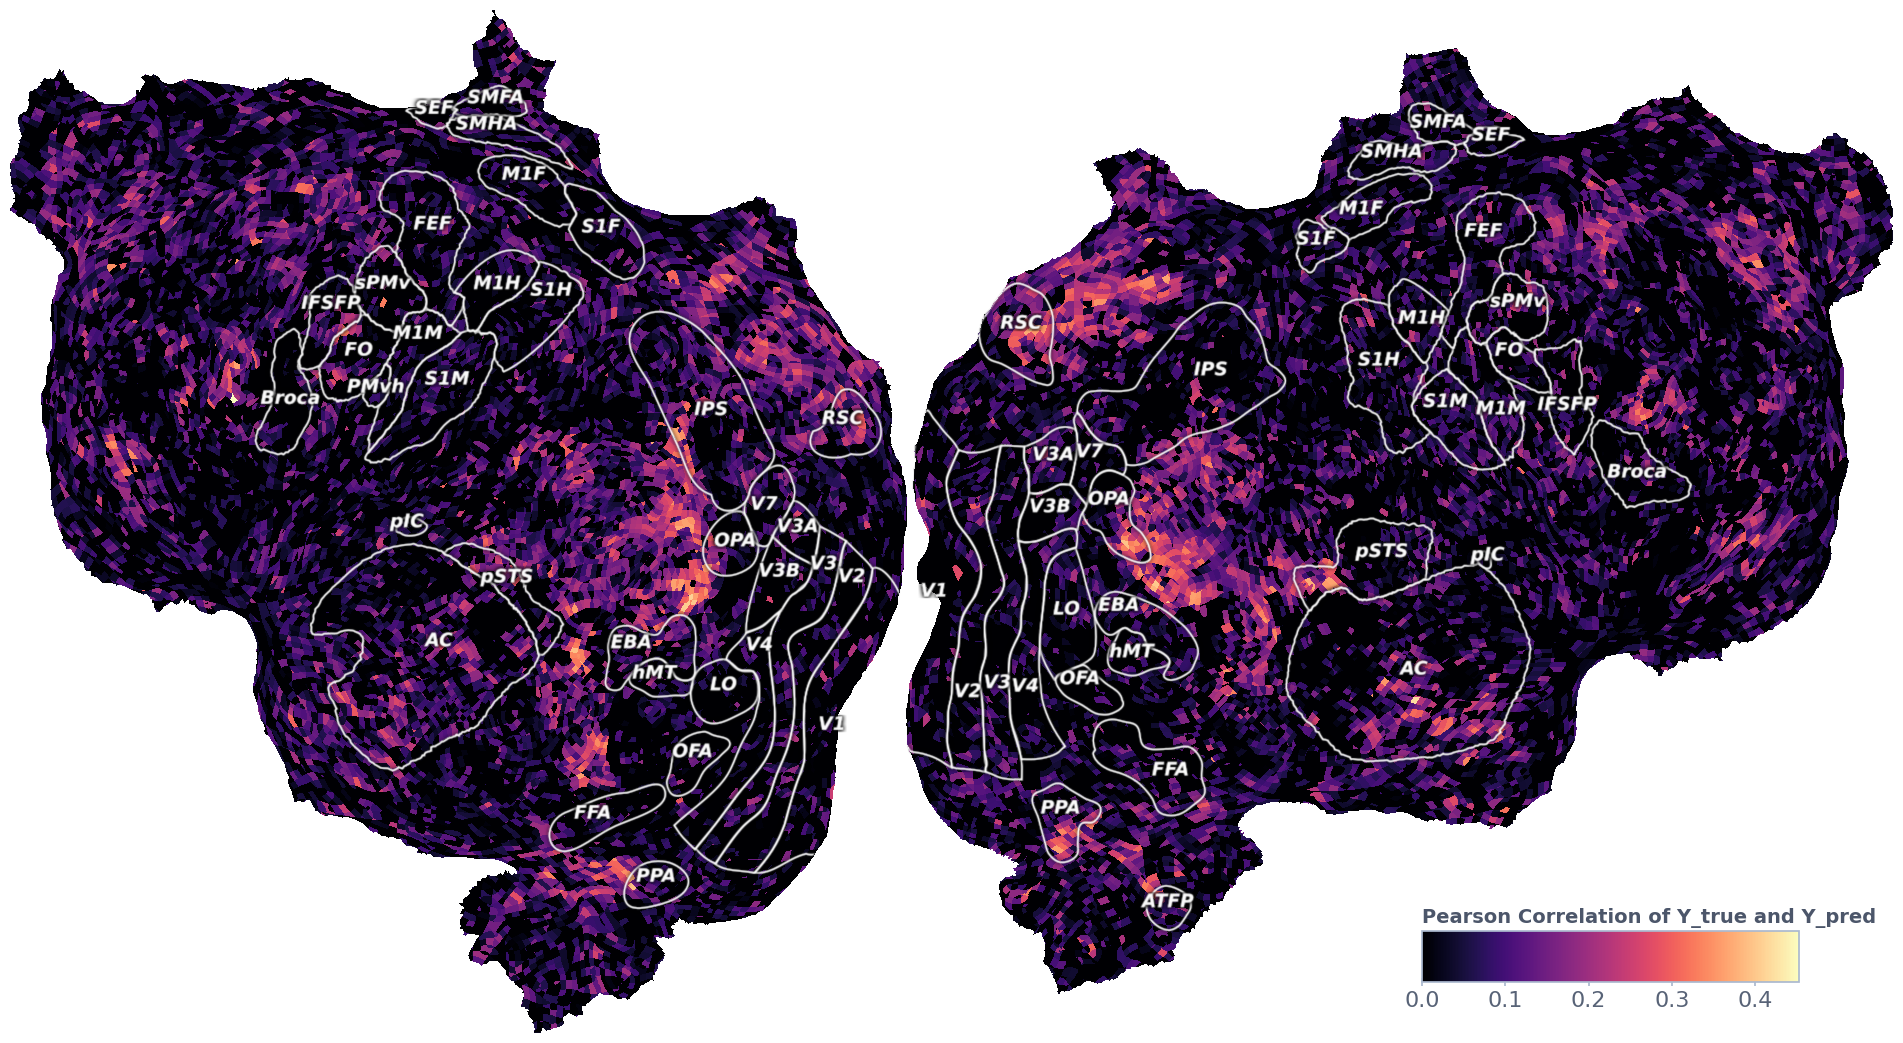

In [69]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

plot_flatmap_from_mapper(semantic_minus_low_level, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=np.max(semantic_minus_low_level), colorbar_location=[0.75, 0.05, 0.2, 0.05])

plt.show()

# Residual Method

## Cross-feature Prediction

In [70]:
from himalaya.ridge import Ridge

solver_params = dict(n_targets_batch=n_targets_batch)
cross_model = Ridge(alpha=1, solver_params=solver_params)
cross_model.fit(low_level_train, semantic_train)

Ridge(solver_params={'n_targets_batch': 100})

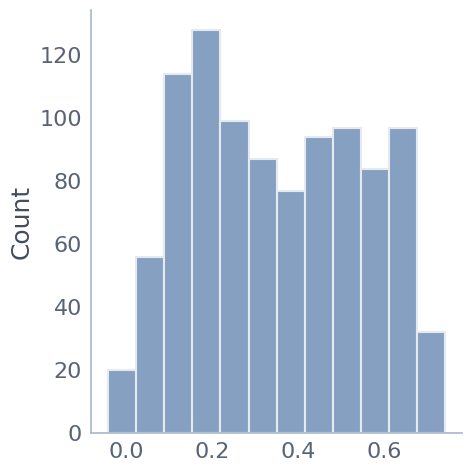

In [84]:
r2_scores = cross_model.score(low_level_val, semantic_val)
r2_scores = r2_scores.cpu().numpy()
sns.displot(r2_scores)

## Create Residuals

In [77]:
semantic_pred_train = cross_model.predict(low_level_train)
semantic_pred_val = cross_model.predict(low_level_val)
print(type(semantic_pred_train))

<class 'torch.Tensor'>


In [78]:
semantic_pred_train = semantic_pred_train.cpu().numpy()
semantic_pred_val = semantic_pred_val.cpu().numpy()
print(semantic_pred_train.shape, semantic_pred_val.shape)

(3887, 985) (306, 985)


In [79]:
semantic_train_residual_train = semantic_train - semantic_pred_train
semantic_val_residual_val = semantic_val - semantic_pred_val

## Train on Residuals

In [81]:
residual_file = os.path.join(get_result_path(modality, subject), f"residual_{feature}_{low_level_feature}_scores.csv")

In [82]:
if not os.path.exists(residual_file):
    print(f"Saving {residual_file}")
    residual_scores = run_pipeline(semantic_train_residual_train, semantic_val_residual_val,
                                   [semantic_train_residual_train.shape[1]], Y_train, Ys_test)
    residual_scores.to_csv(residual_file)
else:
    print(f"Loading {residual_file}")
    residual_scores = pd.read_csv(residual_file, index_col=0)

print("max\n", residual_scores.max(), "\nmin\n", residual_scores.min(), "\nmean\n", residual_scores.mean())

Saving results/reading/subject01/residual_semantic_letters_scores.csv
ColumnTransformerNoStack(transformers=[('feature_0',
                                        Delayer(delays=range(1, 5)),
                                        slice(np.int64(0), np.int64(985), None))])


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[                                        ] 0% | 0.00 sec | 25 random sampling with cv | 

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:140: UserWarning: Solving banded ridge is slower than solving multiple-kernel ridge when n_samples < n_features (here 3887 < 3940). Using linear kernels in himalaya.kernel_ridge.MultipleKernelRidgeCV or himalaya.kernel_ridge.solve_multiple_kernel_ridge_random_search would be faster. Use warn=False to silence this warning.
  warnings.warn(


[........................................] 100% | 1223.33 sec | 25 random sampling with cv | 


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(81133,)


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(81133,)
max
 correlation_score_0    0.488448
correlation_score_1    0.512305
r2_score_0             0.214821
r2_score_1             0.260163
dtype: float64 
min
 correlation_score_0   -0.292987
correlation_score_1   -0.310795
r2_score_0            -0.099928
r2_score_1            -0.164032
dtype: float64 
mean
 correlation_score_0    0.026605
correlation_score_1    0.028950
r2_score_0            -0.000013
r2_score_1             0.000136
dtype: float64


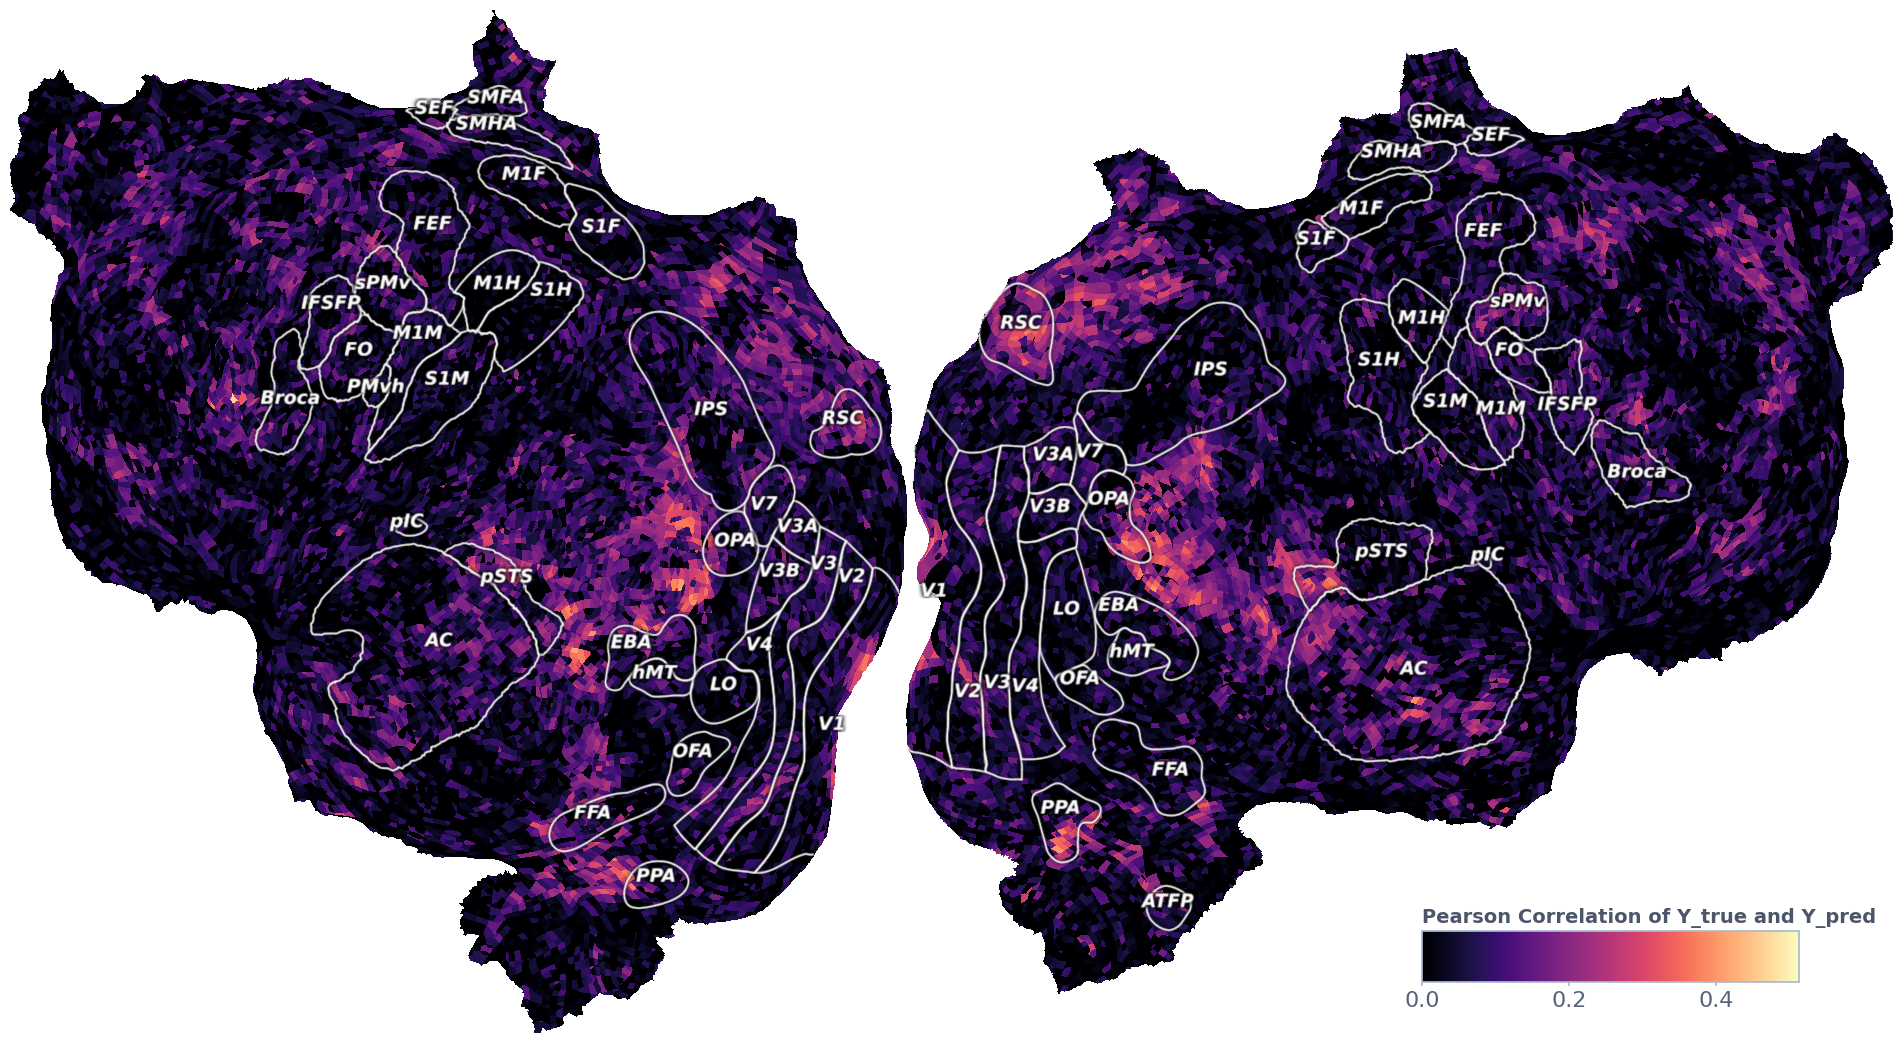

In [85]:
figsize = np.array(flatmap_mask.shape) / 100.
fig = plt.figure(figsize=figsize)
ax = fig.add_axes((0, 0, 1, 1))
ax.axis('off')

residual_correlation = residual_scores['correlation_score_1']
residual_correlation = residual_correlation.to_numpy()
residual_correlation = np.nan_to_num(residual_correlation)

plot_flatmap_from_mapper(residual_correlation, mapper_path, ax=ax, with_curvature=False, alpha=1, vmin=0,
                         vmax=np.max(residual_correlation), colorbar_location=[0.75, 0.05, 0.2, 0.05])

plt.show()